<a href="https://colab.research.google.com/github/anna-dang/dsc-phase-4-project/blob/main/project_4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision: X-Ray Classification using Neural Networks

***TODO Describe data source, competition goal, etc. etc.

Objective: Build a model that can classify whether a given patient has pneumonia, given a chest x-ray image.

Business problem: ******

Stakeholder: *******



### Import libraries

In [1]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import callbacks, models, layers, optimizers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from google.colab import drive
from pandas import Series

np.random.seed(123)

### Define functions

In [2]:
def get_num_images(file_path, form='total'):
    """Follows a filepath for this dataset and counts the images per class of NORMAL or PNEUMONIA X-rays.
        Option to return the 'total' elements per folder or a 'tuple' of the count for each type,
        or the 'normed' count (percentage per class of total).

        Output format: (NORMAL, PNEUMONIA) """
    normal = len(os.listdir(file_path + '/NORMAL'))
    pneum = len(os.listdir(file_path + '/PNEUMONIA'))
    tot = normal + pneum
    if form == 'total':
        return tot
    if form == 'normed':
        return tuple(round(i, 2) for i in ((normal/tot), (pneum/tot)))
    if form == 'tuple':
        return (normal, pneum) 

In [ ]:
# TODO build function to evaulate model and print visuals & scoring metrics/conf matrix

### Download data

In [4]:
# Mount Google Drive files, set up
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [8]:
# Check current directory
os.getcwd()

'/content'

In [6]:
# Define 'local' path as the virtual machine Colab is based on
local_path = '/content'

# Path where data .zip file is stored on Google Drive
zip_path = '/gdrive/MyDrive/kaggle/chest-xray-pneumonia.zip'

# Copy .zip file into local/virtual machine
!cp '{zip_path}' .

In [7]:
# Unzip in local (be sure navigated into '/content')
!unzip -q 'chest-xray-pneumonia.zip'

In [9]:
# Establish file paths for each of the unzipped datap folders on the virtual machine
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
val_path = '/content/chest_xray/val'

# Preview image count per path
[get_num_images(path, form='total') for path in [train_path, test_path, val_path]]

[5216, 624, 16]

In [10]:
# Select images from the training set of each type to preview
norm_img = image.load_img(train_path + '/NORMAL/IM-0274-0001.jpeg')
bac_img = image.load_img(train_path + '/PNEUMONIA/person1000_bacteria_2931.jpeg')
vir_img = image.load_img(train_path + '/PNEUMONIA/person1000_virus_1681.jpeg')

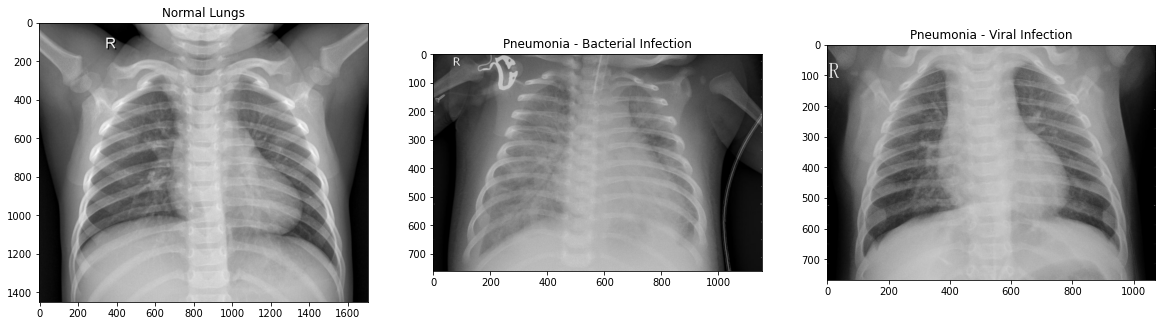

In [11]:
# Preview unprocessed images (keep original aspect ratio)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
axes[0].imshow(norm_img)
axes[1].imshow(bac_img)
axes[2].imshow(vir_img)
axes[0].set_title("Normal Lungs")
axes[1].set_title("Pneumonia - Bacterial Infection")
axes[2].set_title("Pneumonia - Viral Infection")
plt.show()

# Preprocessing



### Format data for Tensorflow/Keras

In [12]:
# Set image size, validation split percentage
img_size = (64, 64)
val_split_size = 0.2

# Instantiate training set image generator with rescale set to reduce RBG values to between 0 and 1
train_datagen = ImageDataGenerator(rescale=(1./255))

# Data is already split into train/test/validation by source, format for Keras
print(" Train:")
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size=img_size,
        class_mode='binary',
        batch_size=get_num_images(train_path)) 

# Create a larger validation set than provided by splitting test set further
# Instantiate test generator with test/validation split, label the subsets
test_val_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=val_split_size)

print("\n Test:")
test_generator = test_val_datagen.flow_from_directory(
        test_path, 
        target_size=img_size,
        class_mode='binary',
        batch_size=get_num_images(test_path),
        subset='training') 

print("\n Validation:")
val_generator = test_val_datagen.flow_from_directory(
        test_path, 
        target_size=img_size,
        class_mode='binary',
        batch_size=get_num_images(test_path),
        subset='validation') 

 Train:
Found 5216 images belonging to 2 classes.

 Test:
Found 500 images belonging to 2 classes.

 Validation:
Found 124 images belonging to 2 classes.


In [13]:
# Check for class types
train_generator.class_indices 

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
# Create the data sets from the generators, split features (images) from target (labels)
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [15]:
# Check that the data was generated properly
# Expect image size to be (quantity, image size x size, 3) and labels (quantity,)
print("Train:", train_images.shape, train_labels.shape)
print("Test:", test_images.shape, test_labels.shape)
print("Val:", val_images.shape, val_labels.shape)

Train: (5216, 64, 64, 3) (5216,)
Test: (500, 64, 64, 3) (500,)
Val: (124, 64, 64, 3) (124,)


In [16]:
# Reshape into single input vector of pixel values for use in fully connected baseline model
train_img_unrow = train_images.reshape(train_images.shape[0], -1)
test_img_unrow = test_images.reshape(test_images.shape[0], -1)
val_img_unrow = val_images.reshape(val_images.shape[0], -1)

In [17]:
# Check shape, expecting: (quantity, (pix x pix x 3 rgb))
print([x.shape for x in [train_img_unrow, test_img_unrow, val_img_unrow]])

[(5216, 12288), (500, 12288), (124, 12288)]


### Inspect processed files

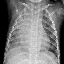

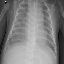

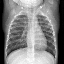

array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 0.], dtype=float32)

In [18]:
# Preview some processed images and labels
[display(array_to_img(train_images[x])) for x in [10, 619, 1000]]
train_labels[100:125]

In [22]:
# Examine the class distribution for each set
display([x.split('/')[-1] for x in [train_path, test_path, val_path]])
display([get_num_images(path, form='tuple') for path in [train_path, test_path, val_path]])
[get_num_images(path, form='normed') for path in [train_path, test_path, val_path]]

['train', 'test', 'val']

[(1341, 3875), (234, 390), (8, 8)]

[(0.26, 0.74), (0.38, 0.62), (0.5, 0.5)]

### Class Imbalance

The training set has unbalanced classes. This could skew the training of the model.


In [25]:
Series(train_labels).value_counts(normalize=True)

1.0    0.742906
0.0    0.257094
dtype: float64

In [ ]:
# TODO correct class imbalance, save as sep variables, test performance of each
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
# from sklearn.utils.class_weight import compute_class_weight
# weights = class_weight('balanced',np.unique(y_train),y_train)
# weights_dict = dict(zip(np.unique(y_train),weights))
# weights_dict 
# ...

# model.fit(X_trian,y_ytrain, class_weight=weights_dict)
# save weights

# Modeling

***TODO train & val sets

***TODO SAVE MODELS!!!!!!!

### Baseline Model

***TODO descfribe methodology here

In [ ]:
# Input shape is the pixel size (unrowed) of one image
unrow_input_shape = train_img_unrow[0].shape

# Build model
model = models.Sequential()
model.add(Dense(units=5, activation='relu', input_shape=unrow_input_shape))
# Output is 1 neuron since our binary class labels are combined into one column of 0/1
model.add(Dense(units=1, activation='sigmoid')) 

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary() 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 5)                 61445     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 61,451
Trainable params: 61,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_img_unrow,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_img_unrow, val_labels))

Epoch 1/10
163/163 [==============================] - 1s 6ms/step - loss: 0.7347 - accuracy: 0.7395 - val_loss: 0.6763 - val_accuracy: 0.6290
Epoch 2/10
163/163 [==============================] - 1s 4ms/step - loss: 0.6446 - accuracy: 0.7429 - val_loss: 0.6655 - val_accuracy: 0.6290
Epoch 3/10
163/163 [==============================] - 1s 4ms/step - loss: 0.6196 - accuracy: 0.7429 - val_loss: 0.6602 - val_accuracy: 0.6290
Epoch 4/10
163/163 [==============================] - 1s 4ms/step - loss: 0.6009 - accuracy: 0.7429 - val_loss: 0.6598 - val_accuracy: 0.6290
Epoch 5/10
163/163 [==============================] - 1s 4ms/step - loss: 0.5877 - accuracy: 0.7429 - val_loss: 0.6632 - val_accuracy: 0.6290
Epoch 6/10
163/163 [==============================] - 1s 4ms/step - loss: 0.5794 - accuracy: 0.7429 - val_loss: 0.6682 - val_accuracy: 0.6290
Epoch 7/10
163/163 [==============================] - 1s 4ms/step - loss: 0.5746 - accuracy: 0.7429 - val_loss: 0.6738 - val_accuracy: 0.6290
Epoch 

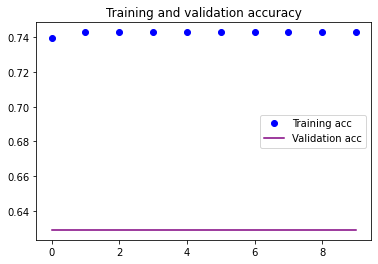

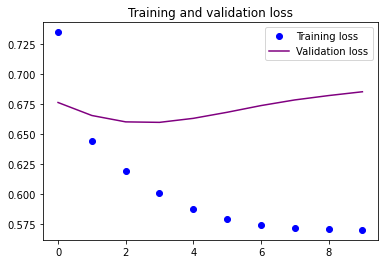

In [ ]:
# TODO visualize model performance curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='purple', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='purple', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# TODO analysis 
results_train = model.evaluate(train_img_unrow, train_labels)
print("Train score:", results_train)
results_test = model.evaluate(test_img_unrow, test_labels)
print("Test score:", results_test)

163/163 [==============================] - 0s 2ms/step - loss: 0.1637 - accuracy: 0.9557
Train score: [0.16372764110565186, 0.9557132124900818]
20/20 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.7885
Test score: [0.632479190826416, 0.7884615659713745]


In [ ]:
# # Save model
# model_path = 'filepath'+'name.hd5'
# model.save(cnn_path)

# # Load model
# model_loaded = load_model(model_path)

### Convolutional Neural Network (CNN)

***TODO explain methodology per iteration

#### Iteration 1

In [ ]:
# since using *image* as input
model.fit_generator()

### Iteration : Image Augmentation

### Iteration : Class Imbalance Corrected

### Iteration : 

# Evaluation

***TODO which metric to use and about how best to cross-validate your 
results on TEST SET

which type of wrong answers are most concerning

High bias favors train perform, high variance favors val perform


In [ ]:
# TODO use TEST set for unbiased eval of model

In [ ]:
# TODO calculate the AUC-ROC to measure your model's discrimination.

In [ ]:
# TODO visualize intermediate layers
# TODO visualize heatmap of image patterns identified (HOW is model working?)

In [ ]:
# Save final model

# Conclusion

***TODO summarize findings, give 3 reccomendations related to business problem and model performance

Be sure notebook answers these questions with clarity:

•	"How did you pick the question(s) that you did?"

•	"Why are these questions important from a business perspective?"

•	"How did you decide on the data cleaning options you performed?"

•	"Why did you choose a given method or library?"

•	"Why did you select these visualizations and what did you learn from each of them?"

•	"Why did you pick those features as predictors?"

•	"How would you interpret the results?"

•	"How confident are you in the predictive quality of the results?"

•	"What are some of the things that could cause the results to be wrong?"
